# Chapter6 The Method of Godunov for Non–linear Systems
## Godunov's method to solve 1 dimensional Euler equations.


### the inviscid Burgers equation
$$u_t + f(u)_x = 0, \quad f(u) = \frac{1}{2}u^2$$
### in the domain $[0, \frac{3}{2}]$ with initial conditions
$$u(x,0) = \begin{cases}
-\frac{1}{2} & \text{if } x \leq \frac{1}{2}, \\
1 & \text{if } \frac{1}{2} \leq x \leq 1, \\
0 & \text{if } x \geq 1.
\end{cases}$$



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display

In [9]:
#Constant parameters
NUM_CELLS = 300

X_DOMAIN = [0, 3/2]
T_DOMAIN = [0, 2]
DX = (X_DOMAIN[1] - X_DOMAIN[0]) / NUM_CELLS
CFL_COEFFICIENT = 0.8

### Initial Conditions for Inviscid Burgers Equation

Inviscid Burgers Equation은 
$$\frac{d\lambda(u)}{du} = \lambda'(u) = f''(u) = 1 > 0 \quad \text{(convex flux)}$$
이므로 u의 값이 클 수 록 유속이 빨라짐.

Initial condition의 각각의 구간을 구간1, 구간2, 구간3이라고 할때, 구간1과 구간2 사이에서는 rarefraction이, 구간2와 구간3 사이에서는 shock가 발생하는 예제임.


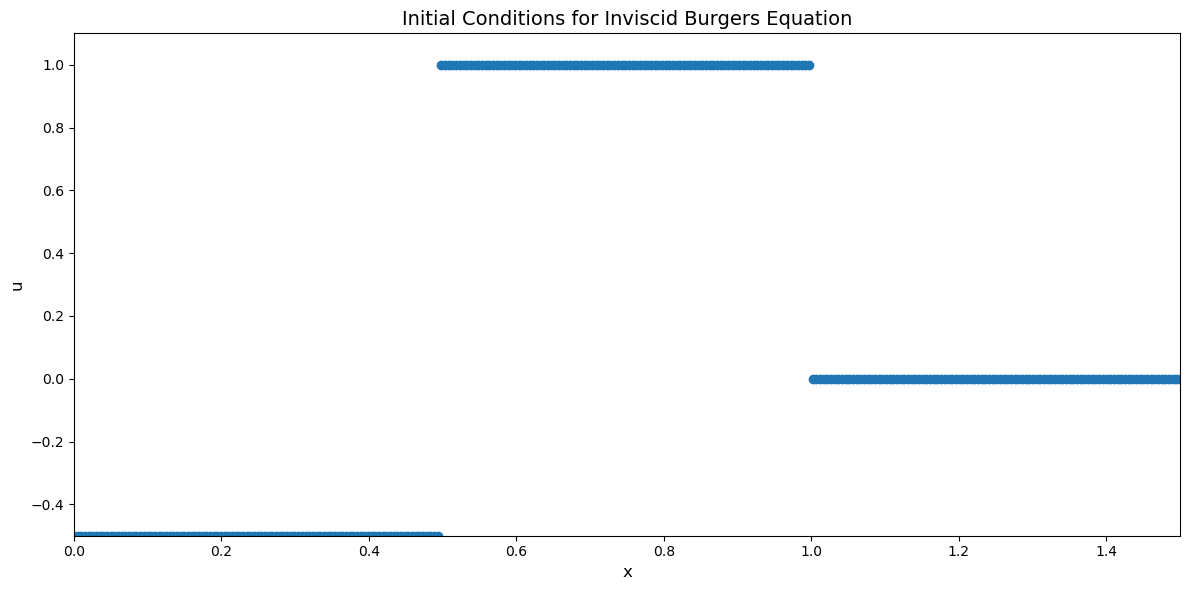

In [10]:
#Initial conditions
CELL = torch.zeros(NUM_CELLS + 2) # +2 for cell boundary
CELL[:int(1/2/DX) + 1] = -1/2
CELL[int(1/2/DX):int(1/DX) + 1] = 1
CELL[int(1/DX) + 1:] = 0

#Plot initial conditions as 1D colored points
u_values = CELL.numpy()
x = np.linspace(X_DOMAIN[0], X_DOMAIN[1], NUM_CELLS + 2)

fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.scatter(x, u_values)
ax.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
ax.set_ylim(-0.5, 1.1)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u', fontsize=12)
ax.set_title('Initial Conditions for Inviscid Burgers Equation', fontsize=14)
plt.tight_layout()
plt.show()


### Riemann problem for Inviscid Burger's Equation

**Shock wave** ($u^n_i > u^n_{i+1}$):
$$u_{i+\frac{1}{2}}(x/t) = \begin{cases}
u^n_i & \text{if } S \geq x/t \\
u^n_{i+1} & \text{if } S \leq x/t
\end{cases}, \quad \text{where } S = \frac{1}{2}(u^n_i + u^n_{i+1})$$

**Rarefaction wave** ($u^n_i \leq u^n_{i+1}$):
$$u_{i+\frac{1}{2}}(x/t) = \begin{cases}
u^n_i & \text{if } x/t \leq u^n_i \\
x/t & \text{if } u^n_i < x/t < u^n_{i+1} \\
u^n_{i+1} & \text{if } x/t \geq u^n_{i+1}
\end{cases}$$

### For Local Riemann problem. the solution is

**Shock wave** ($u^n_i > u^n_{i+1}$):
$$u_{i+\frac{1}{2}}(0) = \begin{cases}
u^n_i & \text{if } S \geq 0 \\
u^n_{i+1} & \text{if } S \leq 0
\end{cases}, \quad \text{where } S = \frac{1}{2}(u^n_i + u^n_{i+1})$$

**Rarefaction wave** ($u^n_i \leq u^n_{i+1}$):
$$u_{i+\frac{1}{2}}(0) = \begin{cases}
u^n_i & \text{if } 0 \leq u^n_i \\
0 & \text{if } u^n_i < 0 < u^n_{i+1} \\
u^n_{i+1} & \text{if } 0 \geq u^n_{i+1}
\end{cases}$$

In [11]:
#Naive way to solve local riemann problem to get u_{i+1/2} unused.
def cal_inter_cell(u_l, u_r):
    #shock wave
    if u_l > u_r:
        S = 0.5 * (u_l + u_r)
        if(S > 0):
            return u_l
        else:
            return u_r
    #rarefaction wave
    else:
        if u_l >= 0:
            return u_l
        elif u_r <= 0:
            return u_r
        else:
            return 0

#vectorized version of local_riemann_problem
#각각의 셀 경계에서의 u_{i+1/2}를 구하는 함수
def cal_inter_cell_u(CELL):
    u_l = CELL[0:-1]
    u_r = CELL[1:]

    #만일 좌우 셀의 유속이 같다면 중간 셀의 유속은 좌우 셀의 유속과 같다.
    inter_cell = u_l.clone()

    #만일 shock가 발생한다면.
    shock_cells = u_l > u_r
    S_times_2 = u_l + u_r
    shock_solution = torch.where(S_times_2 > 0, u_l, u_r)
    inter_cell[shock_cells] = shock_solution[shock_cells]

    #만일 rarefaction이 발생한다면.
    rarefaction_cells = u_l < u_r
    rarefaction_solution = torch.where(u_l > 0, u_l, 0)
    rarefaction_solution = torch.where(u_r < 0, u_r, rarefaction_solution)
    inter_cell[rarefaction_cells] = rarefaction_solution[rarefaction_cells]

    return inter_cell


### the conservative formula
$$u^{n+1}_i = u^n_i + \frac{\Delta t}{\Delta x}\left(f_{i-\frac{1}{2}} - f_{i+\frac{1}{2}}\right)$$

In general, one expresses the Godunov intercell numerical flux as
$$f^{\text{god}}_{i+\frac{1}{2}} = f\left(u_{i+\frac{1}{2}}(0)\right)$$


### dt calculation to satisfy CFL coefficient.

(speed of characteristic) / (speed of cell) <= CFL_COEFFICIENT

--> MAX(|u|) / (DX / DT) = CFL_COEFFICIENT

CFL_COEFFICIENT * (DX / DT) = MAX(u)

DT = CFL_COEFFICIENT * DX / MAX(u)

In [ ]:
def cal_dt(CELL):
    return CFL_COEFFICIENT * DX / CELL.abs().max()

In [13]:
def update(DX, CELL):
    inter_cell = cal_inter_cell_u(CELL)
    inter_cell_flux = 0.5 * inter_cell**2
    dt = cal_dt(CELL)
    CELL[1:-1] = CELL[1:-1] + dt/DX * (inter_cell_flux[0:-1] - inter_cell_flux[1:])

    #boundary condition
    CELL[0] = CELL[1]
    CELL[-1] = CELL[-2]
    
    return CELL, dt


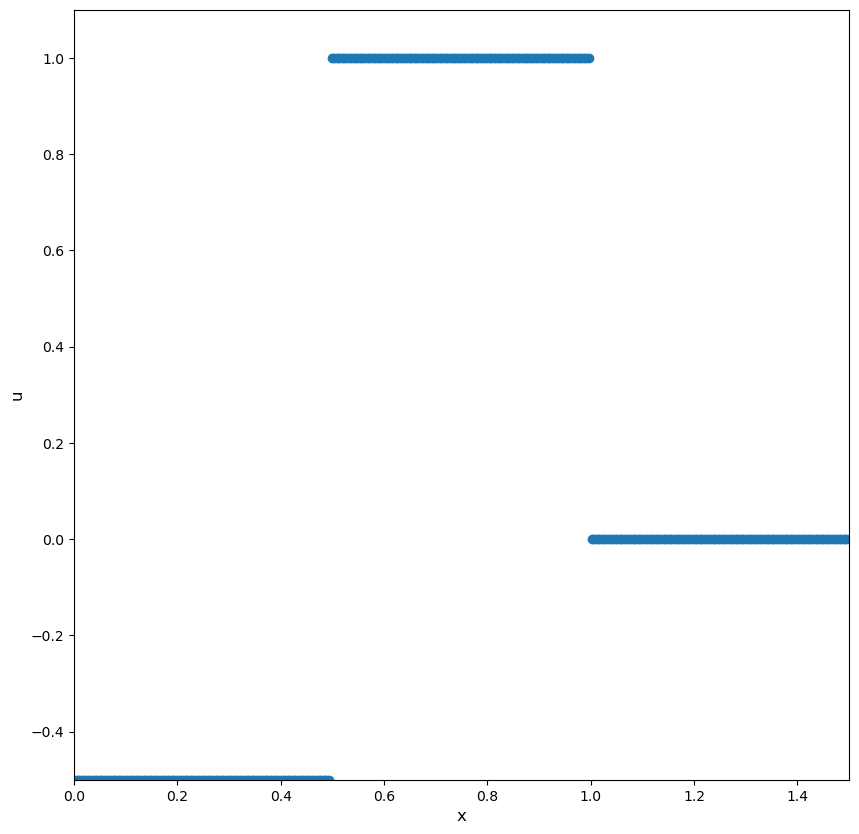

In [14]:
# Setup figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
x = np.linspace(X_DOMAIN[0], X_DOMAIN[1], NUM_CELLS + 2)

# Initial plot
u_initial = CELL.numpy()
scatter = ax.scatter(x, u_values)
ax.set_xlim(X_DOMAIN[0], X_DOMAIN[1])
ax.set_ylim(-0.5, 1.1)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u', fontsize=12)

# Animation parameters
TOTAL_T = T_DOMAIN[1] - T_DOMAIN[0]
t = 0.0

# Animation function
def animate(frame):
    global CELL, t
    
    CELL, dt = update(DX, CELL)
    t = t + dt
    
    # Update scatter plot
    u_values = CELL.numpy()
    scatter.set_offsets(np.c_[x, u_values])
    
    # Update title
    ax.set_title(f'Solution at t = {t:.3f}', fontsize=14)
    return scatter,

In [15]:
def frame_generator():
    global t
    while t < T_DOMAIN[1]:
        yield None


# Create animation
anim = animation.FuncAnimation(fig, animate, frames=frame_generator(), interval=50, blit=True)

/tmp/ipykernel_317419/2453401331.py:8: UserWarning: frames=<generator object frame_generator at 0x72b71b343f40> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = animation.FuncAnimation(fig, animate, frames=frame_generator(), interval=50, blit=True)


In [ ]:
anim.save("Godunov_Inviscid_Burgers_eq.mp4", writer=animation.FFMpegWriter(fps=25))